# 第4章 季節要素のあるローカル・レベルモデル
ローカルレベルモデルに、季節モデルを加える。


$ y_t = \mu_t + \gamma_t + \epsilon_t, 
\hspace{3.5em} \epsilon_t \sim NID(0,{\sigma_\epsilon}^2)$

$ \mu_{t+1} = \mu_t + \xi_t, 
\hspace{3.5em} \xi_t \sim NID(0,{\sigma_\xi}^2)$

$ \gamma_{1,t+1} = -\gamma_{1,t} - \gamma_{2,t} - \gamma_{3,t} + \omega_t
\hspace{3.5em} \omega_t \sim NID(0,{\sigma_\omega}^2)$

## 4.1 確定的レベルと確定的季節要素

$\xi_t=\omega_t = 0$に固定し、t=1での12本の状態方程式の散漫初期値を用いた時系列分析。

In [2]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd

# scipyの統計パッケージも使います。
from scipy import stats

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsa

# 描画のためのライブラリです。
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ブラウザ内に画像を埋め込むための命令です
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

In [3]:
def ShowDiagnostics(res, nMaxLag):
    # Purpose: Show diagnostics table
    # Args:        res:    Result of statsmodels
    #          nMaxLag:    max lag for BoxLjung
    
    ## Get statistics
    # Indipendence check
    Q  = res.test_serial_correlation('ljungbox',nMaxLag)
    Q  = Q[0,0][nMaxLag-1]
    Qc = stats.chi2.ppf(0.95,nMaxLag-len(res.params)+1)
    # Heteroskewdasticity check
    tmp = res.filtered_state.shape # Number of state variables
    n   = tmp[1]
    d   = tmp[0]
    nBlockSize = round((n-d)/3)
    H   = res.test_heteroskedasticity('breakvar')
    H   = H[0,0]
    hflag = 0
    if H < 1:
        H = 1/H
        hflag = 1

    Hc  = stats.f.ppf(0.975,nBlockSize,nBlockSize)
    # Normality check
    N  = res.test_normality('jarquebera')
    N  = N[0,0]
    Nc = stats.chi2.ppf(0.95,2)
    
    value     = np.array([Q,H,N])
    critical  = np.array([Qc,Hc,Nc])
    condition = (value <= critical)
    satisfied = np.where(condition, '+', '-')

    Hstr      = np.where(hflag, '1/H({})'.format(nBlockSize), 'H({})'.format(nBlockSize))

    dfDiag = pd.DataFrame({
        '1. Stat':      ['Q({})'.format(nMaxLag), Hstr, 'N'],
        '2. Value':     value,
        '3. Critical':  critical,
        '4. Satisfied': satisfied},
        index = ['Independence','Homoscedasticity','Normality'])
    
    # Standalized resid
    stdError = res.filter_results.standardized_forecasts_error
    rc  = 2/np.sqrt(n)
    fig = tsa.plot_acf(stdError[0],lags=nMaxLag,alpha=None)
    plt.fill_between(np.arange(1,nMaxLag+1,1),-rc,rc,alpha=0.2)
    
    # Calculate AIC
    AIC = (1/n)*(-2*res.llf+2*(d + len(res.params)))
    print('AIC='+str(AIC))
    
    return dfDiag

In [3]:
#データの読み込み
df = pd.read_table('UKdriversKSI.txt', skiprows=1, header=None)
#インデックスを以下のように設定 (MSは月毎の意味)
df.index = pd.date_range('1969-JAN', '1984-DEC', freq='MS')
#コラム名を変更
df.columns = ['KSI']
#対数KSIを計算してコラムに追加
df['logKSI'] = np.log(df['KSI'])

In [4]:
df.head()

,KSI,logKSI
1969-01-01,1687,7.430707
1969-02-01,1508,7.318540
1969-03-01,1507,7.317876
1969-04-01,1385,7.233455
1969-05-01,1632,7.397562


モデルの作成に以下のツールボックスを用いる。
- http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents

In [13]:
# Deterministic Level & Deterministic Seasonal Model
KSI_DLDSmodel = sm.tsa.UnobservedComponents(df['logKSI'],
                                            seasonal = 12,
                                            level=True,
                                            stochastic_seasonal = False,
                                            irregular=True)
KSI_DLDSres   = KSI_DLDSmodel.fit(method='BFGS')
print(KSI_DLDSres.summary())

Optimization terminated successfully.
         Current function value: -0.477090
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
                          Unobserved Components Results                           
Dep. Variable:                     logKSI   No. Observations:                  192
Model:             deterministic constant   Log Likelihood                  91.601
                           + seasonal(12)   AIC                           -181.203
Date:                    Sun, 21 May 2017   BIC                           -177.945
Time:                            21:48:25   HQIC                          -179.883
Sample:                        01-01-1969                                         
                             - 12-01-1984                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975

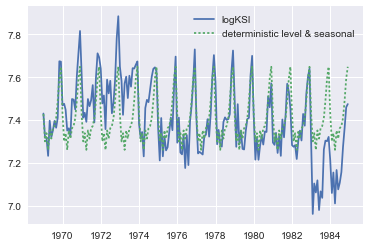

In [6]:
# 確定的レベル+確定的季節要素 (図4.2)
df['DL + DS'] = KSI_DLDSres.smoothed_state[0] + KSI_DLDSres.smoothed_state[1]
df['DL'] = KSI_DLDSres.smoothed_state[0] 
df['DS'] = KSI_DLDSres.smoothed_state[1]
df['irregular'] = df['logKSI']-df['DL + DS']
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.plot(df.index,df['DL + DS'],label='deterministic level & seasonal',linestyle = 'dotted')
plt.legend()

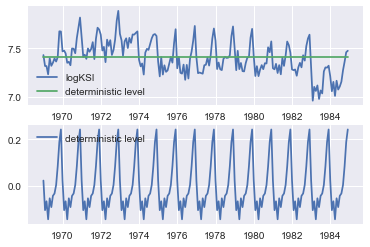

In [7]:
#図4.3及び図4.4のプロット
plt.subplot(2,1,1)
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.plot(df.index,df['DL'],label='deterministic level')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df.index,df['DS'],label='deterministic level')
plt.legend()

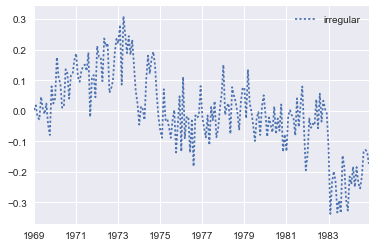

In [8]:
#図4.5のプロット
df.plot(y='irregular',style=':')

AIC=-0.818763154138


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(15),751.575512,24.995790,-
Homoscedasticity,H(60),3.399617,1.666791,-
Normality,N,1.971357,5.991465,+


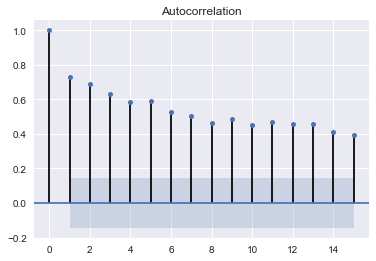

In [9]:
ShowDiagnostics(KSI_DLDSres,15)

AIC=-0.81876は、本の-0.699558と合わない。
以下の計算が違うことから、ツールボックスの対数尤度関数の定義が異なっていると考えられる。


In [10]:
#http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.loglike.html#id2
KSI_DLDSmodel.loglike(KSI_DLDSres.params)

91.601262797220301

# 対数尤度関数の定義
- http://www.statsmodels.org/stable/_modules/statsmodels/regression/linear_model.html#OLS
$ -\frac{n}{2}\log\left(\left(Y-\hat{Y}\right)^{\prime}\left(Y-\hat{Y}\right)\right)-\frac{n}{2}\left(1+\log\left(\frac{2\pi}{n}\right)\right)-\frac{1}{2}\log\left(\left|\Sigma\right|\right)
$

- http://sinhrks.hatenablog.com/entry/2015/05/23/223637
  - ここら辺をよく勉強する必要ある。
  
また、

- http://www.chadfulton.com/topics/implementing_state_space.html
>  loglikelihood[t] = -0.5 * (
            np.log((2*np.pi)**k_endog * determinant) +
            np.dot(forecast_error[:, t], tmp2)
        )

を見ると、やはり対数尤度関数の定義が異なるようである。


## 4.2 確率的レベルと確率的季節要素
レベルと季節要素が、時間で変化することを認める。

In [54]:
# Stochastic Level & Stochastic Seasonal Model
KSI_SLSSmodel = sm.tsa.UnobservedComponents(df['logKSI'],
                                            seasonal = 12,
                                            level    = True,
                                            stochastic_level = True,
                                            stochastic_seasonal = True,
                                            irregular=True)
KSI_SLSSres   = KSI_SLSSmodel.fit()
print(KSI_SLSSres.summary())

                            Unobserved Components Results                            
Dep. Variable:                        logKSI   No. Observations:                  192
Model:                           local level   Log Likelihood                 191.220
                   + stochastic seasonal(12)   AIC                           -376.440
Date:                       Sun, 21 May 2017   BIC                           -366.668
Time:                               22:13:24   HQIC                          -372.483
Sample:                           01-01-1969                                         
                                - 12-01-1984                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0035      0.001      6.043      0

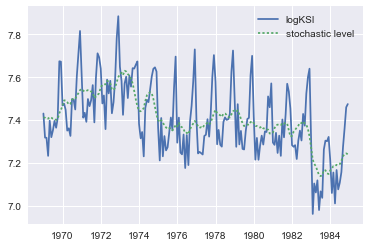

In [56]:
# 確率的レベル(図4.6)
df['SL + SS'] = KSI_SLSSres.smoothed_state[0] + KSI_SLSSres.smoothed_state[1]
df['SL'] = KSI_SLSSres.smoothed_state[0] 
df['SS'] = KSI_SLSSres.smoothed_state[1]
df['irregular-SLSS'] = df['logKSI']-df['SL + SS']
plt.plot(df.index,df['logKSI'],label='logKSI')
plt.plot(df.index,df['SL'],label='stochastic level',linestyle = 'dotted')
plt.legend()

In [57]:
# 確率的季節 (図4.7)

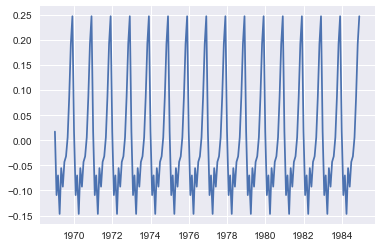

In [58]:
plt.plot(df.index,df['SS'], label='stochastic seasonal')

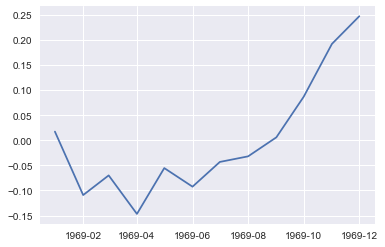

In [59]:
# 確率的季節 (図4.8)
plt.plot(df.index[0:12],df['SS'][0:12], label='seasonal 1969')

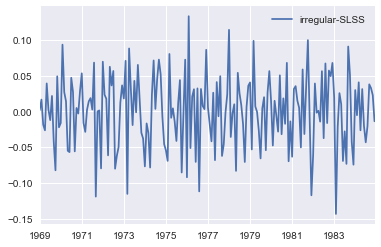

In [60]:
# 確率的レベルと季節モデルに対する不規則要素
df.plot(y='irregular-SLSS')

AIC=-1.83562751992


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(15),14.370210,22.362032,+
Homoscedasticity,H(60),1.092754,1.666791,+
Normality,N,5.156878,5.991465,+


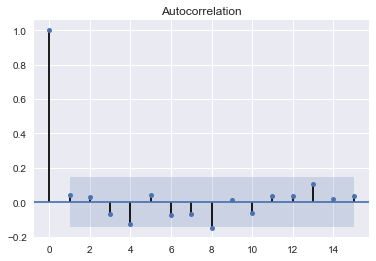

In [61]:
ShowDiagnostics(KSI_SLSSres,15)

## 確率的レベルと確定的季節要素

In [30]:
# Stochastic Level & Deterministic Seasonal Model
KSI_SLDSmodel = sm.tsa.UnobservedComponents(df['logKSI'],
                                            seasonal = 12,
                                            level    = True,
                                            stochastic_level = True,
                                            stochastic_seasonal = False,
                                            irregular=True)
KSI_SLDSres   = KSI_SLDSmodel.fit()
print(KSI_SLDSres.summary())

                        Unobserved Components Results                         
Dep. Variable:                 logKSI   No. Observations:                  192
Model:                    local level   Log Likelihood                 191.220
                       + seasonal(12)   AIC                           -378.440
Date:                Sun, 21 May 2017   BIC                           -371.925
Time:                        22:00:59   HQIC                          -375.802
Sample:                    01-01-1969                                         
                         - 12-01-1984                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0035      0.001      6.646      0.000       0.002       0.005
sigma2.level         0.0009      0

AIC=-1.84604420002


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(15),14.370624,23.684791,+
Homoscedasticity,H(60),1.092754,1.666791,+
Normality,N,5.157385,5.991465,+


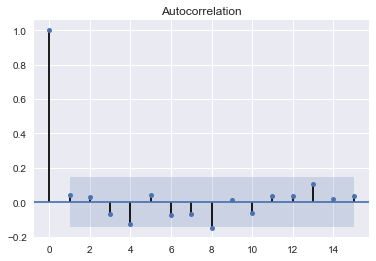

In [31]:
ShowDiagnostics(KSI_SLDSres,15)

SLSSに対して、SLDSがわずかにAICが高い　→　モデルとしての当てはまりが良い。

## 4.4 ローカル・レベルと季節モデルと英国インフレーション
英国インフレーション系列を、確率的レベル、確率的季節、不規則要素によって表す。

In [1]:
!ls

CKbook Chapter 4.ipynb UKinflation.txt        chapter4-4.ox
UKdriversKSI.txt       chapter4-1&4-2&4-3.ox


In [9]:
#データの読み込み
dfUK = pd.read_table('UKinflation.txt', skiprows=1, header=None)
#インデックスを以下のように設定 (MSは月毎の意味)
dfUK.index = pd.date_range('1950-1', '2002-1', freq='Q')
#コラム名を変更
dfUK.columns = ['quarterly price changes in UK']
dfUK.head()

,quarterly price changes in UK
1950-03-31,0.008449
1950-06-30,-0.005049
1950-09-30,0.003846
1950-12-31,0.021429
1951-03-31,0.023284


In [10]:
# Stochastic Level & Stochastic Seasonal Model
UK_SLSSmodel = sm.tsa.UnobservedComponents(dfUK['quarterly price changes in UK'],
                                            seasonal = 4,
                                            level    = True,
                                            stochastic_level = True,
                                            stochastic_seasonal = True,
                                            irregular=True)
UK_SLSSres   = UK_SLSSmodel.fit()
print(UK_SLSSres.summary())

                              Unobserved Components Results                              
Dep. Variable:     quarterly price changes in UK   No. Observations:                  208
Model:                               local level   Log Likelihood                 667.273
                        + stochastic seasonal(4)   AIC                          -1328.545
Date:                           Mon, 22 May 2017   BIC                          -1318.533
Time:                                   22:19:28   HQIC                         -1324.497
Sample:                               03-31-1950                                         
                                    - 12-31-2001                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3.

In [11]:
dfUK['SL'] = UK_SLSSres.smoothed_state[0]
dfUK['SS'] = UK_SLSSres.smoothed_state[1]
dfUK['irregular'] = dfUK['quarterly price changes in UK']-dfUK['SL']--dfUK['SS']

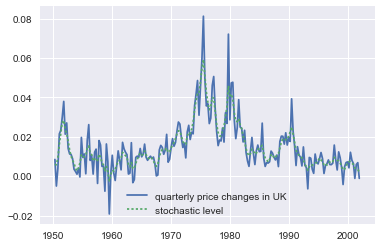

In [18]:
plt.plot(dfUK.index,dfUK['quarterly price changes in UK'],
         label='quarterly price changes in UK')
plt.plot(dfUK.index,dfUK['SL'],linestyle='dotted',
        label='stochastic level')
plt.legend()

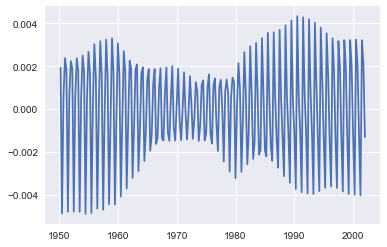

In [20]:
plt.plot(dfUK.index,dfUK['SS'],
        label='stochastic seasonal')

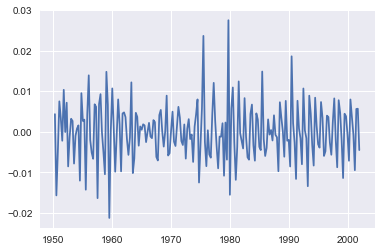

In [21]:
plt.plot(dfUK.index,dfUK['irregular'],
        label='irregular')

AIC=-6.3487754331


,1. Stat,2. Value,3. Critical,4. Satisfied
Independence,Q(10),7.552349,15.507313,+
Homoscedasticity,1/H(68),2.734889,1.615055,-
Normality,N,172.166785,5.991465,-


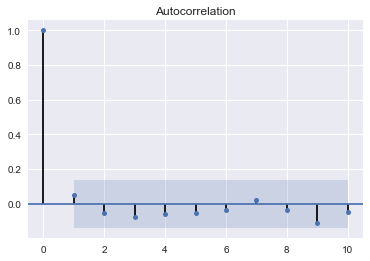

In [22]:
ShowDiagnostics(UK_SLSSres,10)